In [87]:
import sys
import json
import pandas as pd
import numpy as np
import os
from difflib import SequenceMatcher
from bs4 import BeautifulSoup
from pathlib import Path
from importlib.machinery import SourceFileLoader
import api_client
from api_client import *
import random


#api_client = SourceFileLoader("module.name", "../api_client.py").load_module()

DATA_DIR = 'data/'
SOLUTIONS_FILE = ''.join([DATA_DIR, 'solutions_org'])
QUERIES_FILE   = ''.join([DATA_DIR, 'queries_org'])
CAUCUSES_FILE  = ''.join([DATA_DIR, 'caucuses_org'])

MAX_OUTPUT = 1000000

MAX_LENGTH = 1000
orgs_api = ApiClient('http://localhost:3002', '/v1/orgs')
def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    return

def write(df, filename):
    # takes a pandas dataframe and write as json file
    df = df.to_json()
    with open(filename, 'w') as outfile:
        json.dump(df, outfile)
    print('Writing to json file {}'.format(filename))

def read(filename):
    # takes a json filename as input and loads a pandas dataframe
    with open(filename) as data_file:
        solutions = json.load(data_file)
    print('Loading from file ', filename, '...')
    return pd.read_json(solutions)

def length_distribution( solutions_caucus):
    return [len(u.split(' ')) for u in solutions_caucus]

def print_dist(x):
    print('min:',min(x),'mean:',sum(x)/len(x),'max:',max(x))
def load(org_id, option):
    if option     == 'solutions':
        file_init, api_call = SOLUTIONS_FILE, api_client.solutions_api.get
        #params    = {'org_id': org_id, 'is_canonical': 'true'}
        params    = {'org_id': org_id, 'fields': 'content,id,is_active,is_canonical,is_current',
                      'type': 'snippet', 'visibility': 'public'}
    elif option   == 'queries':
        file_init, api_call = QUERIES_FILE, api_client.queries_api.get
        params    = {'org_id': org_id,'fields': 'content,id'}
    elif option   == 'caucuses':
        file_init, api_call = CAUCUSES_FILE, api_client.caucuses_api.get
        params    ={'org_id':org_id}
    else:
        exit('Usage: load( org_id, <solutions, queries or caucuses>) ')

    output_file = ''.join([file_init, str(org_id), '.json']) 

    if Path(output_file).exists():
        print('Downloaded-',option, 'file already exists!')
        final_output = read(output_file)        
    else:
        print('Downloading  and saving ',option)
        limit = 50
        offset = 0
        final_output = []

        while True:
            params['limit'], params['offset'] = limit, offset
            single_output = api_call(params=params).json()
            offset += len(single_output)
            final_output = final_output + single_output
            for sol in single_output:
                if 'content' in sol.keys():
                    # Convert HTML tags
                    sol['content'] = BeautifulSoup(sol['content'], 'html.parser').get_text()               

            if len(final_output)%1000==0:
                print('Fetched %d single_output (total: %d)' % (len(single_output), len(final_output)))
            if len(single_output) == 0 or len(final_output) >= MAX_OUTPUT:
                break
        write(pd.DataFrame(final_output), output_file)
    return pd.DataFrame(final_output)
def query_snippet_caucus(org_id):
    print('Running for org ->', org_id)
    
    output_file = ''.join([CAUCUSES_FILE,'_filtered', str(org_id), '.json'])
    if not Path(output_file).exists():
        
        queries   = load(org_id,'queries')
        solutions = load(org_id,'solutions')
        caucuses  = load(org_id,'caucuses')
        solutions = solutions.rename(columns = {'id':'solution_id','content':'solution_content'})
        queries   = queries.rename(columns = {'id':'query_id','content':'query_content'})    

        caucuses  = pd.merge(caucuses, queries, on='query_id', how='inner')
        caucuses  = pd.merge(caucuses, solutions, on='solution_id', how='inner')
        caucuses  = caucuses[['org_id','query_id', 'solution_id','id','query_content', 'solution_content', 'expert_upvotes','expert_downvotes' ]]

        write(caucuses, output_file)
        print('Summary: caucus_size = ',len(caucuses),', solution_size',len(solutions),',query_size',len(queries),'\n done!')    
    
    else:
        caucuses = read(output_file)
        
    return caucuses

def remove_special_char(string):
    string_in = string
    strings_to_remove = ['Upwork Customer Support | . Blog: Building a Mobile App? A Prototype Saved Our Product and link to https://www.upwork.com/blog/2014/08/building-mobile-app-prototype-saved-product/.'  
                         ,'\"','\'','\r','Hello', 'UNK', 'Thank you for contacting Upwork', 'Support &#124', 
                         'support.upwork.com', 'From the Upwork', 'Thanks for contacting Upwork','Upwork.com.',
                         'Upwork Support Team','High Value Support',
                         'Upwork Marketplace Quality Team'
                        ]
    
    for item in strings_to_remove:
        try:
            string = string.replace(item, '')
        except:
            print(string_in)
    try:
        return string.replace('\n', '.')
    except:
        print(string_in)
        return 'quot; Upwork'

# Download/read the data 
# Remove some words 
# Add negative solutions when they are not present

In [90]:
org_id = 1
caucuses = query_snippet_caucus(org_id)
caucuses_positive = caucuses.loc[caucuses['expert_upvotes'] > caucuses['expert_downvotes'] ]
caucuses_negative = caucuses.loc[caucuses['expert_upvotes'] < caucuses['expert_downvotes'] ]
positive = caucuses_positive[['query_id','query_content','solution_content']].rename(columns = {'solution_content':'solution_content_positive'})
negative = caucuses_negative[['query_id','solution_content']].rename(columns = {'solution_content':'solution_content_negative'})
caucuses_positive_negative =  pd.merge(positive, negative, on='query_id', how='left')
caucuses_positive_negative.drop_duplicates(['query_content','solution_content_positive'], inplace=True)
print(len(caucuses_positive), len(caucuses_negative), len(caucuses_positive_negative)) 

Running for org -> 1
Loading from file  data/caucuses_org_filtered1.json ...
1408 12462 1382


In [91]:
for index, row in caucuses_positive_negative.iterrows():
    row['query_content'] = remove_special_char(row['query_content'])
    row['solution_content_positive'] = remove_special_char(row['solution_content_positive']) 
    row['solution_content_negative'] = remove_special_char(row['solution_content_negative']) 


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


# Tokenization and writing the caucus data

In [106]:
train_dir = '/Users/nikita/nmt_data/Upwork/caucus_positive'
caucuses_positive_negative['query_content'].to_csv(      ''.join([train_dir,'/sources.txt']), index=False,header=False)
caucuses_positive_negative['solution_content_positive'].to_csv(   ''.join([train_dir,'/targets.txt']), index=False,header=False)

train_dir = '/Users/nikita/nmt_data/Upwork/caucus_negative'
caucuses_positive_negative['query_content'].to_csv(      ''.join([train_dir,'/sources.txt']), index=False,header=False)
caucuses_positive_negative['solution_content_negative'].to_csv(   ''.join([train_dir,'/targets.txt']), index=False,header=False)


In [109]:

!bash /Users/nikita/Desktop/seq2seq/bin/data/tokenize.sh Upwork/caucus_positive
!bash /Users/nikita/Desktop/seq2seq/bin/data/tokenize.sh Upwork/caucus_negative
#!scp -r ~/nmt_data/Upwork/caucus_* deep_machine:~/nmt_data/Upwork/

Writing to /Users/nikita/nmt_data/Upwork/caucus_positive. To change this, set the OUTPUT_DIR environment variable.
Tokenizing /Users/nikita/nmt_data/Upwork/caucus_positive/sources.txt...
Tokenizing /Users/nikita/nmt_data/Upwork/caucus_positive/targets.txt...
/Users/nikita/Desktop/seq2seq/bin/data/tokenize.sh: line 51: /Users/nikita/nmt_data/Upwork/caucus_positive/train/sources.tok: No such file or directory
Writing to /Users/nikita/nmt_data/Upwork/caucus_negative. To change this, set the OUTPUT_DIR environment variable.
Tokenizing /Users/nikita/nmt_data/Upwork/caucus_negative/sources.txt...
Tokenizing /Users/nikita/nmt_data/Upwork/caucus_negative/targets.txt...
/Users/nikita/Desktop/seq2seq/bin/data/tokenize.sh: line 51: /Users/nikita/nmt_data/Upwork/caucus_negative/train/sources.tok: No such file or directory


In [92]:
caucuses_positive_negative

,query_id,query_content,solution_content_positive,solution_content_negative
0,36154df6-0f09-4f2e-978d-2da58ec54f6f,"Job Success percentage. Hi Upwork,..My agency ...",The agency owner and all exclusive agency free...,quot; Upwork
1,041e62f4-86df-44b0-b6dc-104329ac3ac2,I am wondering why I have a a lot of oDesk rea...,"All tests are scored on a scale of 0.0 to 5.0,...",Don’t see your skill category? We’re expanding...
21,e0233402-456b-4022-b7cb-d89d96e0ca09,"Sir/Mam, due to some negative feedbacks, i dro...",A current Job Success Score of 90% or higher ...,Don’t see your skill category? We’re expanding...
88,84f34557-d1d3-438c-95ba-074ff7db2ac6,i cant see new job post on my dashboard. I can...,To save a job to return to later: Find a job ...,"Also, due to the double-blind feedback system,..."
145,3f8cb966-c667-4d32-9c8a-2ba3565159b6,Dear sir.I am a new freelancer in upwork. I ha...,If you suspect that someone has compromised yo...,If you have an ongoing connectivity problem th...
214,46ec89a2-9969-4cc7-b018-2f31f09ecb6a,I forgot my forgot Security Question. please h...,If you suspect that someone has compromised yo...,This fee is charged any time you make a paymen...
283,2fa3a95f-b51f-4584-844b-a470eed2122b,Password. Recently resetted password still can...,If you suspect that someone has compromised yo...,"Fixed Price contracts with money in escrow, wi..."
352,37d88db8-eff2-4c7a-98ad-a37ec2843c6d,need my password reset and the security questi...,If you suspect that someone has compromised yo...,Heres how the step by step on how you can upda...
401,1b5b9c53-79d8-4bbe-8d0d-d467c7a74a26,Not able to login my account. I forgot my elem...,If you suspect that someone has compromised yo...,"Also, due to the double-blind feedback system,..."
468,22e99d61-671b-4257-9192-cf9fd643b8ca,"reset password. I try to restore password, but...",If you suspect that someone has compromised yo...,Clients are charged a payment processing fee o...


In [55]:
# a = caucuses_positive_negative.iloc[:10]
# train_dir = '/Users/nikita/nmt_data/Upwork/dev/'
# caucuses_positive_negative['query_content'].to_csv(      ''.join([train_dir,'/sources10.txt']), index=False,header=False)
# caucuses_positive_negative['solution_content_positive'].to_csv(   ''.join([train_dir,'/targets10.txt']), index=False,header=False)

In [78]:
# sample_query = caucuses_positive_negative.iloc[:5]['query_content']
# sample_sol_positive = caucuses_positive_negative.iloc[:5]['solution_content_positive']
# sample_sol_negative = caucuses_positive_negative.iloc[:5]['solution_content_negative']

# sample_query = sample_query.append(sample_query, ignore_index=True)
# sample_solution = sample_sol_positive.append(sample_sol_negative, ignore_index=True)
# train_dir = '/Users/nikita/nmt_data/Upwork/dev/'
# sample_query.to_csv(''.join([train_dir,'/sources10.txt']), index=False,header=False)
# sample_solution.to_csv(   ''.join([train_dir,'/targets10.txt']), index=False,header=False)

In [82]:
# !bash /Users/nikita/Desktop/seq2seq/bin/data/tokenize.sh Upwork/dev
# #!scp -r ~/nmt_data/Upwork/caucus_* deep_machine:~/nmt_data/Upwork/

Writing to /Users/nikita/nmt_data/Upwork/dev. To change this, set the OUTPUT_DIR environment variable.
Tokenizing /Users/nikita/nmt_data/Upwork/dev/sources.txt...
Tokenizing /Users/nikita/nmt_data/Upwork/dev/sources10.txt...
Tokenizing /Users/nikita/nmt_data/Upwork/dev/targets.txt...
Tokenizing /Users/nikita/nmt_data/Upwork/dev/targets10.txt...
/Users/nikita/Desktop/seq2seq/bin/data/tokenize.sh: line 51: /Users/nikita/nmt_data/Upwork/dev/train/sources.tok: No such file or directory


# Length analysis and if the positives are not same as negatives, find new negatives of same length

In [93]:
length_positive = print_dist(length_distribution(caucuses_positive_negative['solution_content_positive'] ))
length_negative = print_dist(length_distribution(caucuses_positive_negative['solution_content_negative'] ))    

min: 1 mean: 61.5246020260492 max: 337
min: 2 mean: 40.36468885672938 max: 233


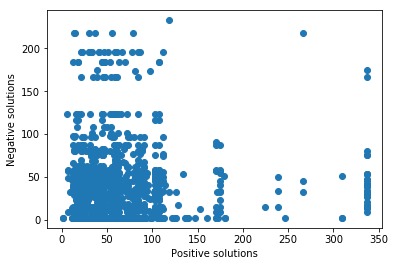

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(length_distribution(caucuses_positive_negative['solution_content_positive'] ),\
            length_distribution(caucuses_positive_negative['solution_content_negative'] ))
plt.ylabel('Negative solutions')
plt.xlabel('Positive solutions')

In [95]:
neg_solutions = pd.DataFrame([[item,len(item.split(' '))] for item in set(caucuses_negative['solution_content'])])

import random
for index, row in caucuses_positive_negative.iterrows():
    len_target = len(row['solution_content_positive'].split(' '))
    if(len_target != len(row['solution_content_negative'].split(' '))):
        
        a = [abs(item - len_target) for item in neg_solutions[1]]
        random.shuffle(a)
        min_index = a.index(min(a))
        row['solution_content_negative'] = neg_solutions[0].iloc[min_index]
        

0

In [96]:
length_positive = print_dist(length_distribution(caucuses_positive_negative['solution_content_positive'] ))
length_negative = print_dist(length_distribution(caucuses_positive_negative['solution_content_negative'] ))


min: 1 mean: 61.5246020260492 max: 337
min: 2 mean: 58.15846599131693 max: 636


In [102]:
caucuses_positive_negative

,query_id,query_content,solution_content_positive,solution_content_negative
0,36154df6-0f09-4f2e-978d-2da58ec54f6f,"Job Success percentage. Hi Upwork,..My agency ...",The agency owner and all exclusive agency free...,Your Job Success Score (JSS) is a measure of y...
1,041e62f4-86df-44b0-b6dc-104329ac3ac2,I am wondering why I have a a lot of oDesk rea...,"All tests are scored on a scale of 0.0 to 5.0,...","When a contract ends, clients usually leave yo..."
21,e0233402-456b-4022-b7cb-d89d96e0ca09,"Sir/Mam, due to some negative feedbacks, i dro...",A current Job Success Score of 90% or higher ...,How Upwork handles disputed charges: We can't...
88,84f34557-d1d3-438c-95ba-074ff7db2ac6,i cant see new job post on my dashboard. I can...,To save a job to return to later: Find a job ...,"Yes, you can be both a freelancer and a client..."
145,3f8cb966-c667-4d32-9c8a-2ba3565159b6,Dear sir.I am a new freelancer in upwork. I ha...,If you suspect that someone has compromised yo...,If you are hiring on behalf of multiple busine...
214,46ec89a2-9969-4cc7-b018-2f31f09ecb6a,I forgot my forgot Security Question. please h...,If you suspect that someone has compromised yo...,Every Monday you'll be invoiced for the previo...
283,2fa3a95f-b51f-4584-844b-a470eed2122b,Password. Recently resetted password still can...,If you suspect that someone has compromised yo...,Additional benefits of Pro include: Exclusive...
352,37d88db8-eff2-4c7a-98ad-a37ec2843c6d,need my password reset and the security questi...,If you suspect that someone has compromised yo...,Yes! Freelancers who have hired on Upwork shar...
401,1b5b9c53-79d8-4bbe-8d0d-d467c7a74a26,Not able to login my account. I forgot my elem...,If you suspect that someone has compromised yo...,The short answer is yes. Here's the long answe...
468,22e99d61-671b-4257-9192-cf9fd643b8ca,"reset password. I try to restore password, but...",If you suspect that someone has compromised yo...,When you submit a proposal for a job the Upwor...


In [103]:
caucuses_positive_negative['solution_content_positive'][0]

'The agency owner and all exclusive agency freelancers who have completed enough contracts to qualify for a Job Success score will see their agency score listed on their profile. Agency owners are responsible for the all work of their agencies and agency freelancers, so their profiles reflect the collective Job Success scores of their agencies rather than their personal ratings.'

In [104]:
caucuses_positive_negative['solution_content_negative'][0]

"Your Job Success Score (JSS) is a measure of your client's satisfaction with your work and success on Upwork. Talented freelancers who deliver high-quality work to their clients find that the scores on their profiles help them promote their freelance businesses in the Upwork marketplace and win new clients.  How is My Job Success Score Calculated? When is My Job Success Score Calculated? I don't have a Job Success Score yet. When will I get one? "

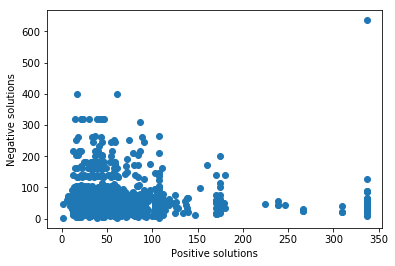

In [105]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(length_distribution(caucuses_positive_negative['solution_content_positive'] ),\
            length_distribution(caucuses_positive_negative['solution_content_negative'] ))
plt.ylabel('Negative solutions')
plt.xlabel('Positive solutions')